In [1]:
import ee, geemap, folium, numpy as np, pandas as pd, matplotlib.pyplot as plt

try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='solina-456116')

Choosing Rzeszów area containing urban and forest areas.

In [2]:
rzeszow = ee.Geometry.Point([22.001, 50.041])

In [3]:
half_size = 8000
aoi = rzeszow.buffer(half_size).bounds()

def mask_clouds(img):
    qa = img.select('QA60')
    cloud = qa.bitwiseAnd(1 << 10).neq(0)
    cirrus = qa.bitwiseAnd(1 << 11).neq(0)
    return img.updateMask(cloud.Or(cirrus).Not())

s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(aoi)
      .filterDate('2024-05-01', '2024-09-30')
      .map(mask_clouds)
      .median()
      .clip(aoi))

Interactive choosing of wanted areas - more effective than clipping tiles

In [5]:
rgb = s2.visualize(bands=['B4','B3','B2'], min=0, max=3000)


m = geemap.Map(center=[50.041, 22.001], zoom=12)
m.add_layer(rgb, {}, 'Sentinel-2 RGB')
m.add_layer(aoi, {'color': 'yellow'}, 'AOI')

m.add_draw_control()

print("Draw two ROIs on the map:")
print("   - forested area (forest)")
print("   - urban area (urban)")
m

Draw two ROIs on the map:
   - forested area (forest)
   - urban area (urban)


Map(center=[50.041, 22.001], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [6]:
drawn_fc = m.user_rois  
drawn_list = drawn_fc.toList(drawn_fc.size())

In [7]:
forest_poly = ee.Feature(drawn_list.get(0)).set({'class': 0})
urban_poly  = ee.Feature(drawn_list.get(1)).set({'class': 1})


In [8]:
forest_fc = ee.FeatureCollection([forest_poly])
urban_fc  = ee.FeatureCollection([urban_poly])
training_fc = forest_fc.merge(urban_fc)

In [9]:
drawn_fc.size().getInfo()

2

In [10]:
m2 = geemap.Map(center=[50.041, 22.001], zoom=12)
m2.add_layer(rgb, {}, 'Sentinel-2 RGB')
m2.add_layer(forest_fc.style(color='blue', fillColor='0000FF55'), {}, 'Forest')
m2.add_layer(urban_fc.style(color='red',  fillColor='FF000055'), {}, 'Urban')
m2

Map(center=[50.041, 22.001], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [12]:
m.save('rzeszow_sentinel2_drawn_rois.html')

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
nir = s2.select('B8')
red = s2.select('B4')
green = s2.select('B3')
swir = s2.select('B11')
blue = s2.select('B2')

In [15]:
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
ndbi = swir.subtract(nir).divide(swir.add(nir)).rename('NDBI')
ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
bright = blue.add(green).add(red).divide(3).rename('BRIGHT')
feat_img = ndvi.addBands([ndbi, ndwi, bright])

Why those four features (NDVI, NDBI, NDWI, and BRIGHT)? \
When trying to separate two classes of land cover — forest vs urban — based on how their pixels behave spectrally, a single raw Sentinel-2 band (like Red or NIR) doesn’t have a very clean separation between classes.
But certain band combinations (indices) enhance specific characteristics of vegetation, built-up surfaces, and water.
When plotting histograms of these indices for each class, one can see clear statistical differences, which the Bayes classifier exploits.

In [16]:
sample_scale = 10  # 10m for Sentinel-2
samples = feat_img.sampleRegions(
    collection=training_fc,
    properties=['class'],
    scale=sample_scale,
    geometries=False
)

import tempfile, os
tmpfile = os.path.join(tempfile.gettempdir(), "samples.csv")

geemap.ee_to_csv(samples, filename=tmpfile)
print("Export ended:", tmpfile)


import pandas as pd
samples_df = pd.read_csv(tmpfile)
samples_df.head()

Export ended: C:\Users\Klaudia\AppData\Local\Temp\samples.csv


,BRIGHT,NDBI,NDVI,NDWI,class
0,461.833333,-0.403093,0.844145,-0.752251,0
1,480.666667,-0.387349,0.835737,-0.742684,0
2,459.666667,-0.357303,0.833893,-0.742237,0
3,459.666667,-0.357303,0.833893,-0.742237,0
4,419.333333,-0.326951,0.824810,-0.740222,0


Respective histograms and parametric models for their PDFs 

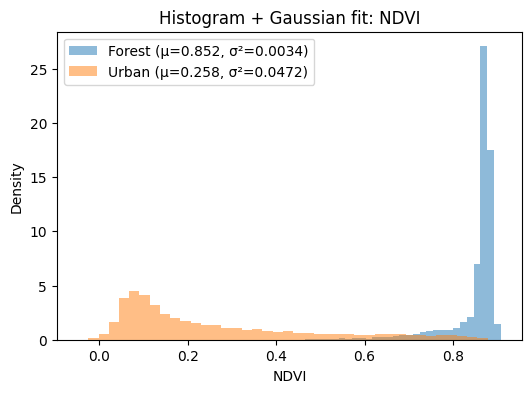

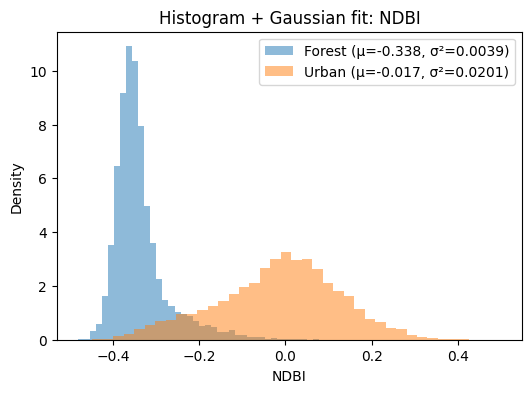

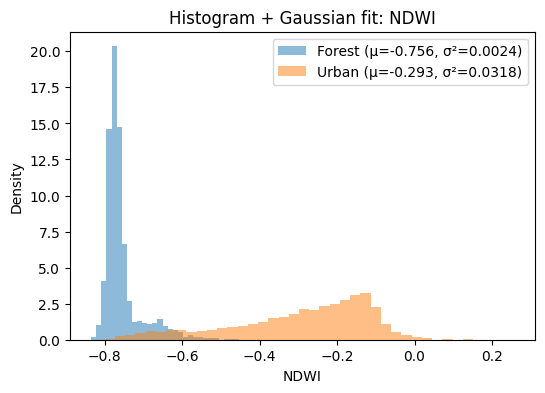

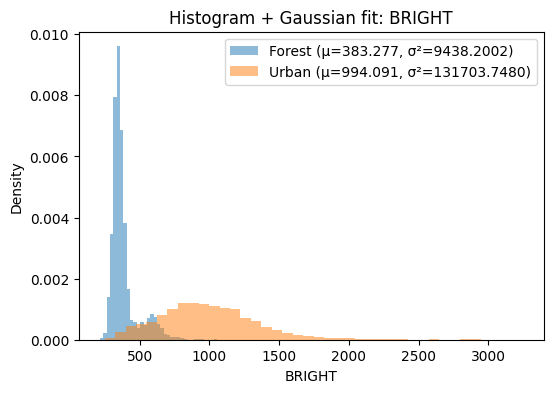


 Estimated Gaussian parameters:

Class 0 (Forest)
  NDVI: μ = 0.8517, σ² = 0.0034
  NDBI: μ = -0.3378, σ² = 0.0039
  NDWI: μ = -0.7560, σ² = 0.0024
  BRIGHT: μ = 383.2767, σ² = 9438.2002

Class 1 (Urban)
  NDVI: μ = 0.2582, σ² = 0.0472
  NDBI: μ = -0.0170, σ² = 0.0201
  NDWI: μ = -0.2932, σ² = 0.0318
  BRIGHT: μ = 994.0906, σ² = 131703.7480


In [17]:
#0=forest, 1=urban
features = ['NDVI', 'NDBI', 'NDWI', 'BRIGHT']

params = {}  
classes = [0, 1]
labels = {0: 'Forest', 1: 'Urban'}

for feat in features:
    plt.figure(figsize=(6,4))
    for cls in classes:
        data = samples_df[samples_df['class'] == cls][feat].dropna()
        if len(data) == 0:
            continue

        mu = data.mean()
        var = data.var(ddof=1)
        params[(cls, feat)] = (mu, var)

        plt.hist(data, bins=40, alpha=0.5, density=True, label=f"{labels[cls]} (μ={mu:.3f}, σ²={var:.4f})")

    plt.title(f"Histogram + Gaussian fit: {feat}")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

print("\n Estimated Gaussian parameters:")
for cls in classes:
    print(f"\nClass {cls} ({labels[cls]})")
    for feat in features:
        mu, var = params.get((cls, feat), (np.nan, np.nan))
        print(f"  {feat}: μ = {mu:.4f}, σ² = {var:.4f}")


NDVI and NDBI give the clearest separation, NDWI and BRIGHT add support for the Bayes classifier.

In [18]:
# Priors based on sample counts
n_forest = (samples_df['class'] == 0).sum()
n_urban  = (samples_df['class'] == 1).sum()
p_forest = n_forest / (n_forest + n_urban)
p_urban  = n_urban  / (n_forest + n_urban)

print(f"Priors: forest={p_forest:.3f}, urban={p_urban:.3f}")

# helper to pack params into Earth Engine dict
def ee_params_for_class(cls):
    d = {}
    for feat in ['NDVI', 'NDBI', 'NDWI', 'BRIGHT']:
        mu, var = params[(cls, feat)]
        d[f"{feat}_mu"]  = mu
        d[f"{feat}_var"] = max(var, 1e-6)
    return ee.Dictionary(d)

param_forest = ee_params_for_class(0)
param_urban  = ee_params_for_class(1)

# log-likelihood for Gaussian Naive Bayes
def log_likelihood(img, param_dict):
    two_pi = ee.Number(2 * np.pi)
    ll = ee.Image(0)
    for feat in ['NDVI', 'NDBI', 'NDWI', 'BRIGHT']:
        x   = img.select(feat)
        mu  = ee.Image.constant(param_dict.get(f"{feat}_mu"))
        var = ee.Image.constant(param_dict.get(f"{feat}_var"))
        term = (ee.Image.constant(-0.5)
                .multiply(var.log().add(two_pi.log()))
                .subtract(x.subtract(mu).pow(2).divide(var.multiply(2))))
        ll = ll.add(term)
    return ll

# log-posterior = log p(x|ω) + log P(ω)
ll_forest = log_likelihood(feat_img, param_forest).add(np.log(p_forest))
ll_urban  = log_likelihood(feat_img, param_urban).add(np.log(p_urban))

# classify: 1 = urban, 0 = forest
classified = ll_urban.gt(ll_forest).rename('class_pred')

# Color mask: red=urban, blue=forest
urban_rgb  = ee.Image.constant([1, 0, 0]).updateMask(classified.eq(1))
forest_rgb = ee.Image.constant([0, 0, 1]).updateMask(classified.eq(0))
viz_rgb = ee.Image.cat([
    forest_rgb.select(0).unmask().rename('R'),
    forest_rgb.select(1).unmask().rename('G'),
    forest_rgb.select(2).unmask().rename('B')
])
viz_rgb = viz_rgb.blend(urban_rgb)

m = geemap.Map(center=[50.041, 22.001], zoom=12)
m.add_layer(s2.select(['B4','B3','B2']).visualize(min=0, max=3000), {}, 'Sentinel-2 RGB')
m.add_layer(viz_rgb, {'min':0,'max':1}, 'Bayes classification (red=urban, blue=forest)')
m.add_layer(forest_fc.style(color='blue', fillColor='0000FF55'), {}, 'Forest polygons')
m.add_layer(urban_fc.style(color='red',  fillColor='FF000055'), {}, 'Urban polygons')
m.add_colorbar_branca(colors=['blue','red'], vmin=0, vmax=1, index=[0,1], caption='0=Forest | 1=Urban')
m


Priors: forest=0.464, urban=0.536


Map(center=[50.041, 22.001], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [19]:
m.save('rzeszow_sentinel2_bayes.html')

The map shows the output of the Gaussian Naïve Bayes classifier applied pixel-by-pixel to the Sentinel-2 tile.
Each pixel was assigned to the class (forest or urban) with the higher posterior probability

𝑃(𝜔𝑘∣𝑥) ∝ 𝑝(𝑥∣𝜔𝑘)𝑃(𝜔𝑘)

Red areas → pixels classified as urban
(high NDBI, high brightness, low NDVI — typical for built-up zones and roads).

Blue areas → pixels classified as forest
(high NDVI, low brightness, negative NDBI — typical for vegetated regions).

Outcome - pretty impressive

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

now - kNN Classifier \
80% of the data (training) to learn patterns, remaining 20% (testing)

In [40]:
samples_df = samples_df.dropna(subset=['NDVI','NDBI','NDWI','BRIGHT'])
samples_df = samples_df.sample(frac=1, random_state=0)  # shuffle
train_df = samples_df.sample(frac=0.8, random_state=42)
test_df  = samples_df.drop(train_df.index)

X_train = train_df[['NDVI','NDBI','NDWI','BRIGHT']].values
y_train = train_df['class'].values
X_test  = test_df[['NDVI','NDBI','NDWI','BRIGHT']].values
y_test  = test_df['class'].values

Euclidean distance between feature vectors \
computes the Euclidean distance between two feature vectors (different like e.g. Cosine are also possible, but Euclidean is a "go-to")

In [41]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def knn_predict(X_train, y_train, x, k=3):
    distances = [euclidean(x, xi) for xi in X_train]
    k_idx = np.argsort(distances)[:k]
    k_labels = y_train[k_idx]
    most_common = Counter(k_labels).most_common(1)[0][0]
    return most_common

classifier for different k values \
repeats the evaluation for three neighbourhood sizes (k = 1, 3, 5)

In [42]:
def evaluate_knn(k):
    preds = [knn_predict(X_train, y_train, x, k) for x in X_test]
    acc = np.mean(np.array(preds) == y_test)
    return acc

for k in [1, 3, 5]:
    acc = evaluate_knn(k)
    print(f"k = {k} → accuracy = {acc:.3f}")

k = 1 → accuracy = 0.966
k = 3 → accuracy = 0.928
k = 5 → accuracy = 0.933


|   k   |  Accuracy | \
| **1** | **0.966** | Highest accuracy, but may overfit — very sensitive to noise or outliers.         \
| **3** | **0.928** | Slightly lower accuracy, but smoother decision boundaries and less noise.       \
| **5** | **0.933** | Similar to k=3 — boundaries smoother, small patches absorbed by majority class. 


The k-NN classifier achieves high accuracy (≈93–97%), confirming strong separability between forest and urban classes in the NDVI–NDBI–NDWI–BRIGHT feature space.
Increasing k reduces overfitting but slightly lowers precision near class boundaries.

Full image visualization (in Earth Engine) \
*NOT FROM SCRATCH = JUST TO SEE AND COMPARE*

In [23]:
feat_img = ndvi.addBands([ndbi, ndwi, bright])


sample_scale = 10  
training_fc = feat_img.sampleRegions(
    collection=forest_fc.merge(urban_fc),
    properties=['class'],
    scale=sample_scale,
    geometries=False
)

In [24]:
print(training_fc.first().toDictionary().getInfo())

{'BRIGHT': 461.8333333333333, 'NDBI': -0.4030927009053762, 'NDVI': 0.8441449031171019, 'NDWI': -0.7522513508104863, 'class': 0}


In [25]:
for k in [1, 3, 5]:
    knn = ee.Classifier.smileKNN(k=k).train(
        features=training_fc,
        classProperty='class',
        inputProperties=['NDVI','NDBI','NDWI','BRIGHT']
    )
    classified = feat_img.classify(knn)
    m.add_layer(
        classified,
        {'min':0, 'max':1, 'palette':['0000FF','FF0000']},
        f'kNN k={k}'
    )

In [26]:
m

Map(bottom=355733.0, center=[50.041, 22.001], controls=(WidgetControl(options=['position', 'transparent_bg'], …

In [27]:
m.save('rzeszow_sentinel2_knn.html')

For k=1, the resulting map is fragmented and “salt-and-peppery". For k=3 it's more balanced. In k=5, small forest or urban patches get smoothed over.